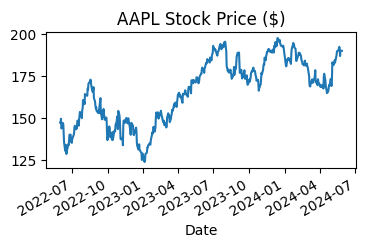

In [1]:
import yfinance
import numpy as np
from matplotlib import pyplot as plt


def get_stock_price(ticker):
    stock = yfinance.Ticker(ticker)
    return stock.history(period="2y")


ticker = "AAPL"
stock_price_df = get_stock_price(ticker)

# Basic Stock Chart
plt.figure(figsize=(4, 2))
stock_price_df["Close"].plot(title=f"{ticker} Stock Price ($)")
plt.show()

In [2]:
# Compute daily returns to estimate mu and sigma for the stock's GBM model.
# Note that this is very rough estimation and should not be used for actual trading.

# Split for training period
train_data = stock_price_df["Close"][: int(0.8 * len(stock_price_df))]

# Set initial price and prices
initial_price = train_data.values[0]
prices = list(train_data.values)


def daily_return(prices):
    returns = []
    for i in range(0, len(prices) - 1):
        today = prices[i + 1]
        yesterday = prices[i]

        daily_return = (today - yesterday) / yesterday
        returns.append(daily_return)
    return returns


returns = daily_return(prices)

# Compute mu and sigma
mu = np.mean(returns) * len(returns)
sigma = np.std(returns) * np.sqrt(len(returns))
print(f"Estimated mu: {mu} / sigma: {sigma}")

Estimated mu: 0.28855579793911385 / sigma: 0.34370997906850564


In [3]:
"""
GBM Parameters:
    S_o - initial stock price
    MU - the mean of returns
    SIGMA - standard deviation of returns (volatility)
    W - Brownian motion
    T - time horizon
    N - number of intervals
"""

S_0 = initial_price
MU = mu
SIGMA = sigma
T = 1.0
N = len(stock_price_df)
print(f"Initial price: {S_0:.4f} / mu: {MU:.4f} / sigma: {SIGMA:.4f} / N: {N} / T: {T}")


class GBM_Simulator:
    def __init__(self, s_0, mu, sigma, N, T):
        self.s_0 = s_0
        self.mu = mu
        self.sigma = sigma
        self.N = N
        self.T = T
        self.dt = T / N
        self.t = np.linspace(0.0, T, N)

    def BrownianMotion(self):
        zs = np.random.randn(self.N)  # random variables
        zs[0] = 0

        dW = np.sqrt(self.dt) * zs  # single Brownian increment
        W = np.cumsum(dW)  # Brownian path
        return W

    def RunGBM(self):
        W = self.BrownianMotion()

        sim_prices = []
        sim_prices.append(self.s_0)

        for i in range(1, self.N):
            drift = (self.mu - 0.5 * self.sigma**2) * self.t[
                i
            ]  # Calculating the deterministic part
            diffusion = self.sigma * W[i - 1]  # Calculating the stochastic part
            s_i = self.s_0 * np.exp(drift + diffusion)
            sim_prices.append(s_i)

        return sim_prices


simulator = GBM_Simulator(S_0, MU, SIGMA, N, T)

Initial price: 147.1749 / mu: 0.2886 / sigma: 0.3437 / N: 501 / T: 1.0


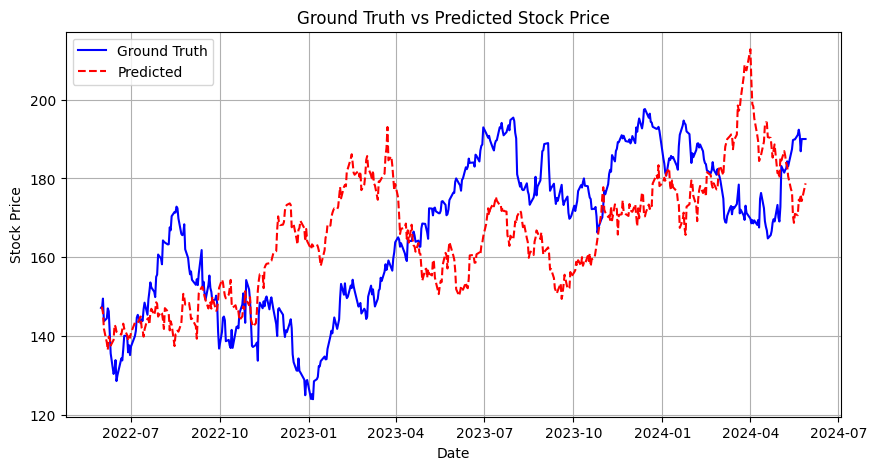

In [6]:
# Single Simulation of GBM

simulated_pred = simulator.RunGBM()

plt.figure(figsize=(10, 5))
plt.plot(
    stock_price_df.index, stock_price_df["Close"], label="Ground Truth", color="blue"
)
plt.plot(
    stock_price_df.index, simulated_pred, label="Predicted", color="red", linestyle="--"
)
plt.title("Ground Truth vs Predicted Stock Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

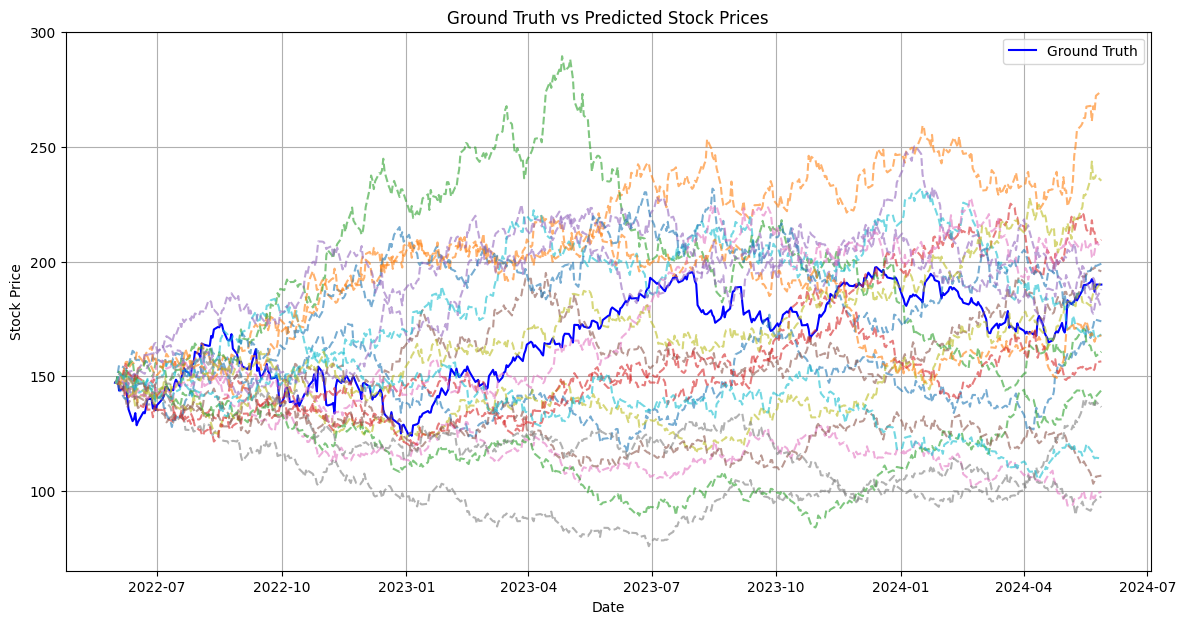

In [5]:
# Multiple Simulations of GBM

# Number of simulations
num_simulations = 20

# Running multiple simulations
simulated_preds = [simulator.RunGBM() for _ in range(num_simulations)]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(
    stock_price_df.index, stock_price_df["Close"], label="Ground Truth", color="blue"
)

# Plot each simulation's predictions
for i, simulated_pred in enumerate(simulated_preds):
    plt.plot(
        stock_price_df.index,
        simulated_pred,
        linestyle="--",
        alpha=0.6,
    )

plt.title("Ground Truth vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()